In [1]:
# install dependencies: (use cu101 because colab has CUDA 10.1)
!pip install -U torch==1.5 torchvision==0.6 -f https://download.pytorch.org/whl/cu101/torch_stable.html 
!pip install cython pyyaml==5.1
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version

Looking in links: https://download.pytorch.org/whl/cu101/torch_stable.html
ERROR: Could not find a version that satisfies the requirement torch==1.5 (from versions: 1.11.0, 1.12.0, 1.12.1, 1.13.0, 1.13.1, 2.0.0, 2.0.1, 2.1.0, 2.1.1, 2.1.2, 2.2.0, 2.2.1, 2.2.2)
ERROR: No matching distribution found for torch==1.5
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 274.2/274.2 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [34 lines of output]
      Traceback (most recent call last):
        File "<string>", line 2, in <module>
        File "<pip-setuptools-caller>", line 34, in <module>
        File "/tmp/pip-install-51w2muta/pyyaml_27b2f0be6c9b4642af32261c3086064b/setup.py", line 291, in <module>
          setup(
        File "/opt/conda/lib/python3.10/site-packages/setuptools/_distutils/core.py", line 185, in setup
          return run_commands(dist)
 

In [2]:
pip install 'git+https://github.com/facebookresearch/detectron2.git@v0.5'

  Cloning https://github.com/facebookresearch/detectron2.git (to revision v0.5) to /tmp/pip-req-build-eledsybs
  Running command git clone --filter=blob:none --quiet https://github.com/facebookresearch/detectron2.git /tmp/pip-req-build-eledsybs
  Running command git checkout -q 82a57ce0b70057685962b352535147d9a8118578
  Resolved https://github.com/facebookresearch/detectron2.git to commit 82a57ce0b70057685962b352535147d9a8118578
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.2/50.2 kB 2.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.0/117.0 kB 6.2 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.0/131.0 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 11.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [3]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random


# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog
from detectron2.data.catalog import DatasetCatalog

In [4]:
from detectron2.data.datasets import register_coco_instances
register_coco_instances("my_dataset_train", {}, "/kaggle/input/sat-coco/train/_annotations.coco.json", "/kaggle/input/sat-coco/train")
register_coco_instances("my_dataset_val", {}, "/kaggle/input/sat-coco/valid/_annotations.coco.json", "/kaggle/input/sat-coco/valid")
register_coco_instances("my_dataset_test", {}, "/kaggle/input/sat-coco/test/_annotations.coco.json", "/kaggle/input/sat-coco/test")

WARNING [04/09 06:51:04 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 06:51:04 d2.data.datasets.coco]: Loaded 1472 images in COCO format from /kaggle/input/sat-coco/train/_annotations.coco.json


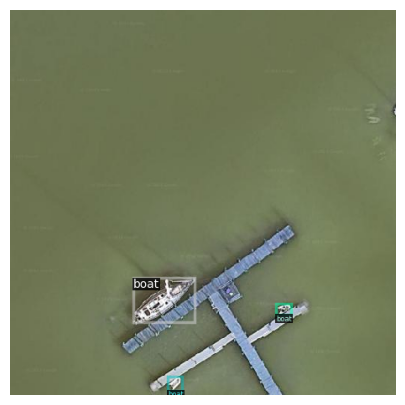

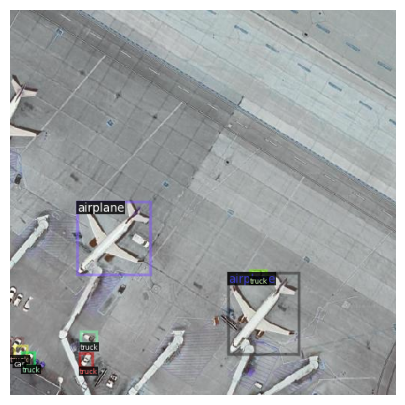

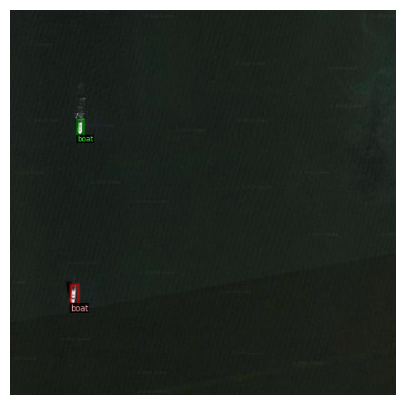

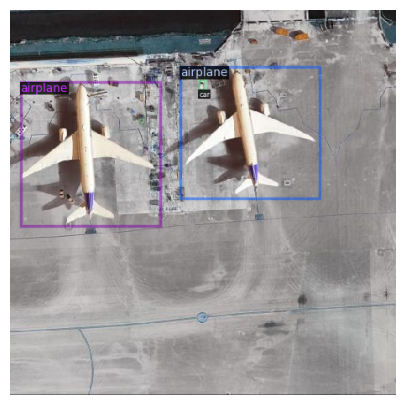

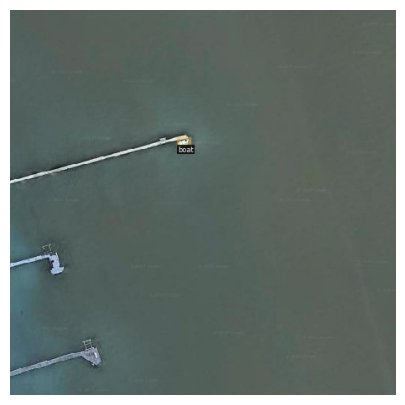

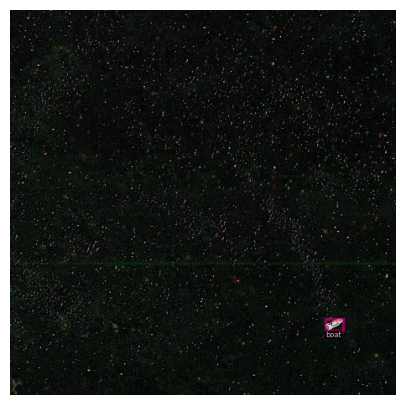

In [5]:
#visualize training data
my_dataset_train_metadata = MetadataCatalog.get("my_dataset_train")
dataset_dicts = DatasetCatalog.get("my_dataset_train")

import random
from detectron2.utils.visualizer import Visualizer

import matplotlib.pyplot as plt

# Assuming you already have the 'vis' object from your code
for d in random.sample(dataset_dicts, 6):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=my_dataset_train_metadata, scale=0.9)
    vis = visualizer.draw_dataset_dict(d)
    
    plt.figure(figsize=(10, 5))
    plt.imshow(vis.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()


In [6]:
# Update class labels in metadata
MetadataCatalog.get("my_dataset_train").thing_classes = ["car-plane-boat", "airplane", "boat", "car", "cargo ship", "fighter jet", "helicopter", "jet", "military aircraft", "propeller plane", "truck", "yacht"]

from detectron2.engine import DefaultTrainer
from detectron2.evaluation import COCOEvaluator
from detectron2.config import get_cfg
import os

class CocoTrainer(DefaultTrainer):

    @classmethod
    def build_evaluator(cls, cfg, dataset_name, output_folder=None):
        if output_folder is None:
            os.makedirs("coco_eval", exist_ok=True)
            output_folder = "coco_eval"
        return COCOEvaluator(dataset_name, cfg, False, output_folder)


In [7]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-Detection/retinanet_R_101_FPN_3x.yaml"))

# Update number of classes in ROI heads
cfg.MODEL.RETINANET.NUM_CLASSES = len(MetadataCatalog.get("my_dataset_train").thing_classes)

cfg.DATASETS.TRAIN = ("my_dataset_train",)
cfg.DATASETS.TEST = ("my_dataset_val",)

cfg.DATALOADER.NUM_WORKERS = 4
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Detection/retinanet_R_101_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001

cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 5000
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = 12  # Default to 12 for compatibility with COCO evaluator

cfg.TEST.EVAL_PERIOD = 500

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
trainer.train()

[04/09 06:51:07 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

2024-04-09 06:51:10.527355: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-04-09 06:51:10.527468: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-04-09 06:51:10.701761: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
model_final_971ab9.pkl: 228MB [00:01, 193MB/s]                           


[04/09 06:51:21 d2.engine.train_loop]: Starting training from iteration 0


/opt/conda/lib/python3.10/site-packages/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/opt/conda/lib/python3.10/site-packages/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /usr/local/src/pytorch/torch/csrc/utils/tensor_new.cpp:261.)
  tensor = torch.as_tensor(tensor, dtype=torch.float32, device=device)
/opt/conda/lib/python3.10/site-packages/detectron2/structures/boxes.py:158: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely 

[04/09 06:51:43 d2.utils.events]:  eta: 1:06:24  iter: 19  total_loss: 2.396  loss_cls: 1.687  loss_box_reg: 0.551  time: 0.9489  data_time: 0.0202  lr: 1.931e-06  max_mem: 3593M
[04/09 06:52:01 d2.utils.events]:  eta: 1:07:05  iter: 39  total_loss: 1.162  loss_cls: 0.8334  loss_box_reg: 0.3208  time: 0.9066  data_time: 0.0108  lr: 2.911e-06  max_mem: 3593M
[04/09 06:52:18 d2.utils.events]:  eta: 1:08:09  iter: 59  total_loss: 1.182  loss_cls: 0.8383  loss_box_reg: 0.3234  time: 0.9024  data_time: 0.0100  lr: 3.891e-06  max_mem: 3593M
[04/09 06:52:37 d2.utils.events]:  eta: 1:09:29  iter: 79  total_loss: 1.328  loss_cls: 1.045  loss_box_reg: 0.3129  time: 0.9044  data_time: 0.0107  lr: 4.871e-06  max_mem: 3593M
[04/09 06:52:56 d2.utils.events]:  eta: 1:15:51  iter: 99  total_loss: 1.029  loss_cls: 0.7866  loss_box_reg: 0.2241  time: 0.9120  data_time: 0.0103  lr: 5.851e-06  max_mem: 3593M
[04/09 06:53:14 d2.utils.events]:  eta: 1:15:55  iter: 119  total_loss: 1.028  loss_cls: 0.8224  l

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader
from detectron2.evaluation import COCOEvaluator, inference_on_dataset

cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.85
predictor = DefaultPredictor(cfg)
evaluator = COCOEvaluator("my_dataset_test", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "my_dataset_test")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [04/09 08:16:45 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass in explicit arguments instead.
WARNING [04/09 08:16:45 d2.data.datasets.coco]: 
Category ids in annotations are not in [1, #categories]! We'll apply a mapping for you.

[04/09 08:16:45 d2.data.datasets.coco]: Loaded 208 images in COCO format from /kaggle/input/sat-coco/test/_annotations.coco.json
[04/09 08:16:45 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[04/09 08:16:45 d2.data.common]: Serializing 208 elements to byte tensors and concatenating them all ...
[04/09 08:16:45 d2.data.common]: Serialized dataset takes 0.12 MiB
[04/09 08:16:45 d2.evaluation.evaluator]: Start inference on 208 batches
[04/09 08:16:47 d2.evaluation.evaluator]: Inference done 11/208. Dataloading: 0.0009 s/iter. Inference: 0.1022 s/iter. Eval: 0.0004 s/iter.

OrderedDict([('bbox',
              {'AP': 13.348411670407495,
               'AP50': 21.608185497804286,
               'AP75': 15.0280349592182,
               'APs': 13.204964302299866,
               'APm': 14.957814687564145,
               'APl': 10.418883984035121,
               'AP-car-plane-boat': nan,
               'AP-airplane': 12.7006097410987,
               'AP-boat': 27.49900364499026,
               'AP-car': 21.348473495898098,
               'AP-cargo ship': 0.17126036928017127,
               'AP-fighter jet': 23.099123954207993,
               'AP-helicopter': 14.936223703238817,
               'AP-jet': 15.392065732417748,
               'AP-military aircraft': 7.987649617270902,
               'AP-propeller plane': 19.592025814515125,
               'AP-truck': 3.2062523175662214,
               'AP-yacht': 0.8998399839983998})])

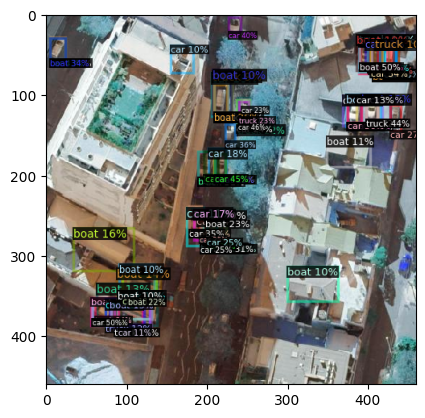

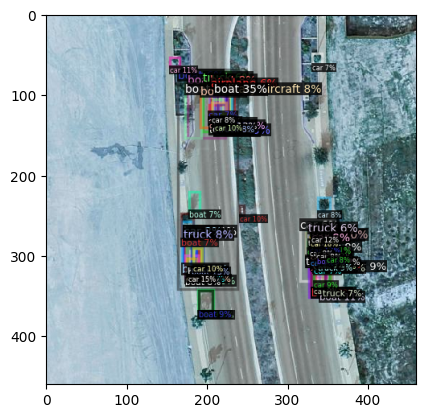

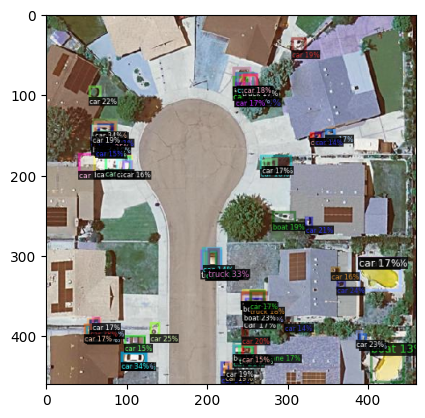

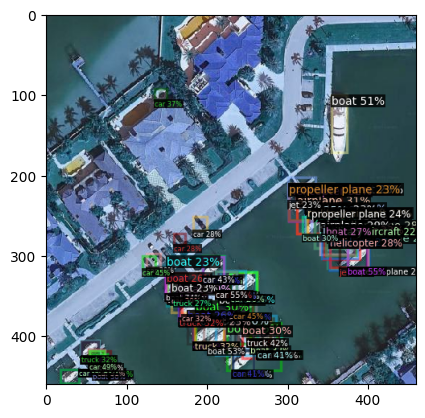

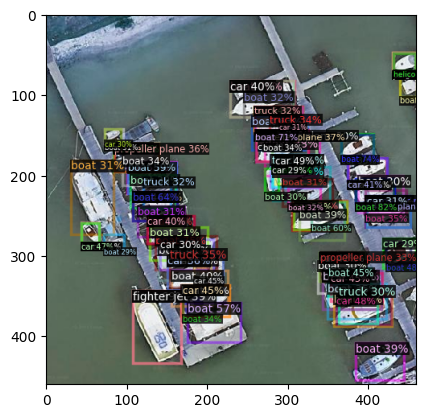

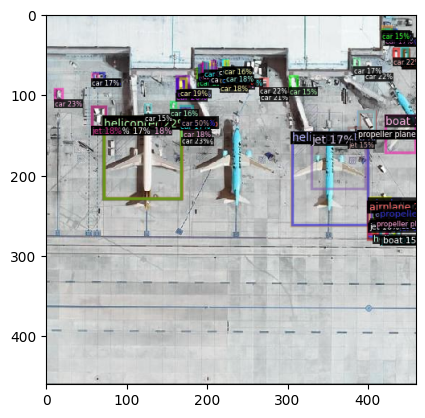

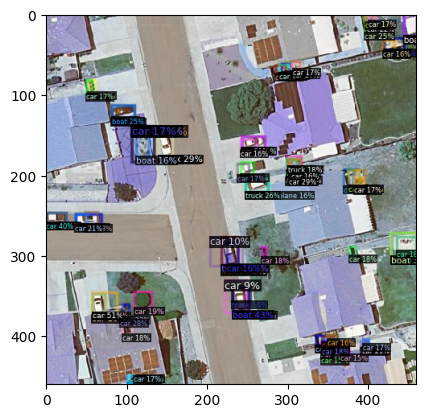

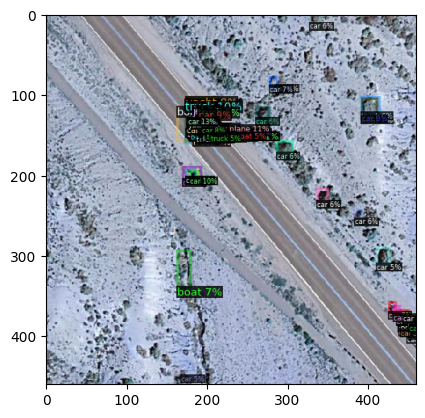

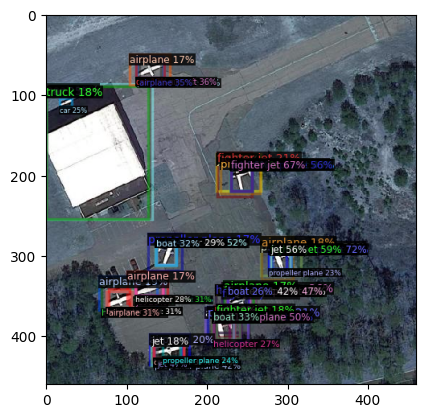

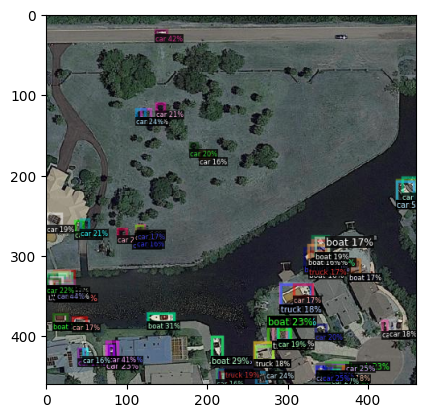

In [9]:
import random
from detectron2.utils.visualizer import Visualizer, ColorMode
from matplotlib import pyplot as plt
import cv2
import glob
from detectron2.data import DatasetCatalog

# Assuming you have already registered your datasets
my_dataset_test_metadata = MetadataCatalog.get("my_dataset_test")

# Get a list of all image file paths
image_paths = glob.glob('/kaggle/input/sat-coco/test/*jpg')

# Select 10 random image file paths
random_image_paths = random.sample(image_paths, 10)

for image_path in random_image_paths:
    im = cv2.imread(image_path)
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1], metadata=my_dataset_test_metadata, scale=0.9, 
                   instance_mode=ColorMode.IMAGE_BW)  # Change ColorMode to ColorMode.IMAGE_BW
    out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.show()
